# Using Protein Language Models on A Downstream Task

This notebook allows you to represent protein sequences via protein language models and to use the representations on protein phosphorylation prediction task. In this notebook, you can represent the protein sequences as One-hot Encodings, [ProtVec](https://arxiv.org/abs/1503.05140), [ProtBERT](https://arxiv.org/abs/2007.06225), and [ESM2](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1.full.pdf) embedding vectors. By using these vector representations, you can train a 2-layer neural network to predict if a given protein sequence is phosphorylated or not. 

### Import Libraries

In [1]:
# Loading protein language models (plm)
from transformers import AutoModel, AutoTokenizer

# Embedding manipulation
import torch
import torch.nn as nn
import torch.optim as optim

# Data preperation
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re

# Evaluation
from sklearn.metrics import f1_score, roc_auc_score

# Visualization
from matplotlib import pyplot as plt

# Measure timing
import time

## LOAD DATA and PreProcess

* Data is provided as "phosphorylation_data.csv"
* The phosphorylated peptides were obtained from [PhosphositePlus](https://www.phosphosite.org/staticDownloads). However, there is no such set as an experimentally unphosphorylated peptide. For this reason, in accordance with the [literature](https://pubmed.ncbi.nlm.nih.gov/20702892/), we generated the unphosphorylated peptide data by following the following steps: i) The phosphorylated amino acid of the 15-long phosphorylated peptide sequence is found, which corresponds to the 8th amino acid. ii) The protein sequence containing the phosphosite has an amino acid that is the same as the phosphorylated amino acid (for example, Serine) but is not reported to be phosphorylated in PhosphositePlus. iii) The detected amino acid is combined with a peptide sequence of 7 to the right and 7 to the left to create 15-long unphosphorylated peptide sequences.
* In the data there are 4 columns: 
  * **SUB_ACC_ID**: Uniprot accession ID 
  * **SUB_MOD_RSD**: Location of phosphorylated residue in the peptid sequence
  * **SITE_+/-7_AA**: Phosphorylated sequence
  * **NON_PH_SITE**: Non-phosphorylated sequence"phosphorylation_data.csv

In [2]:
## Load Data 
data = pd.read_csv("phosphorylation_data.csv", index_col=0)
data.head()

,SUB_ACC_ID,SUB_MOD_RSD,SITE_+/-7_AA,NON_PH_SITE
0,Q8R3W2,S119,NPFYEPNSPIRSSAF,LPAGKAESKDEHRHL
1,Q9CTA4,S10,RPPPGSRSTVAQSPP,RRRPPPGSRSTVAQS
2,Q9CTA4,T11,PPPGSRSTVAQSPPQ,RRDPGSATPAASRPT
3,P31946,T2,______MTMDKSELV,ISSIEQKTERNEKKQ
4,Q9CQV8,T2,______MTMDKSELV,ISSIEQKTERNEKKQ


In [3]:
## Seperate positive(phosphorylated) and negative(non-phosphorylated) data samples
pos_data = data["SITE_+/-7_AA"].tolist()
neg_data = data["NON_PH_SITE"].tolist()

## Create labels. 1: phosphorylated, 0:non-phosphorylated
pos_labels = [1]*len(pos_data)
neg_labels = [0]*len(neg_data)

## TASK1 - Obtaining Protein Representations
* Onehot: Peptid sequence is expressed as a binary vector of amino acids. It creates 300 dimensional vector.
* Protvec: A skip-gram neural network model trained to provide a continuous representation of protein sequences. ProtVec provides a 100-dimensional embedding for each 3-gram, the average of the embeddings is used to represent the sequence.
* ProtBERT: A transformer based model presented in [ProtTrans](https://arxiv.org/abs/2007.06225) paper. Embedding vectors has 1024 dimension per residue. Model is avaliable in HuggingFace: [ProtBERT HuggingFace](https://huggingface.co/Rostlab/prot_bert)
* ESM2: A transformer based model presented in [ESM2](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1.full.pdf) paper. There are different versions of ESM2, each has distinct number of parameters. In this notebook, due to the time constraint, we will use ESM2 with 8M parameters. Embedding vectors has 320 dimension per residue. Model is avaliable in HuggingFace: [ESM2_8M HuggingFace](https://huggingface.co/facebook/esm2_t6_8M_UR50D)
  



In [4]:
## Take sample sequences
sample_ph1, sample_ph2 = pos_data[0], pos_data[5]
sample_ph1, sample_ph2

('NPFYEPNSPIRSSAF', '__MTMDKSELVQKAK')

### One-hot Encoding

* Each residue is represented as a one-hot vector according to the index in predefined **AMINO_ACIDS**.
* After obtaining each residue's one-hot representation, you can concatenate them to get sequence's representations
* Some sequences contain "gap(_)". Here, gaps will be represented as 0-vectors. 

In [5]:
# Amino acides
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'

def one_hot_encode(sequence):
    one_hot = np.zeros((len(sequence), len(AMINO_ACIDS)), dtype=int)
    
    for i, amino_acid in enumerate(sequence):
        if amino_acid == '_':
            continue
        elif amino_acid in AMINO_ACIDS:
            index = AMINO_ACIDS.index(amino_acid)
            one_hot[i, index] = 1
        else:
            print(f"Unknown amino acid: {amino_acid}")
    
    return np.concatenate(one_hot, axis=0).flatten().tolist()

# One-hot representations of sample sequences
encoded_sequence = one_hot_encode(sample_ph1.upper())
print("Sequence:", sample_ph1)
print("One-hot encoding:", encoded_sequence)
print("Length of the encoding:", len(encoded_sequence))
print()
encoded_sequence = one_hot_encode(sample_ph2.upper())
print("Sequence:", sample_ph2)
print("One-hot encoding:", encoded_sequence)
print("Length of the encoding:", len(encoded_sequence))

Sequence: NPFYEPNSPIRSSAF
One-hot encoding: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length of the encoding: 300

Sequence: __MTMDKSELVQKAK


### ProtVec
* Each consecutive 3-grams are represented as 100-dimensional vector.
* For each combination of 3-grams, embedding vectors are pre-calculated and shared in "protvec_embeddings.txt" 
* 3-grams containing gaps are represented as 0-vectors.
* After obtaining vector representations of 3-grams for a sequence, columnwise average will be considered as a sequence representation

In [6]:
# read pre-calculated trigram vectors
def read_trigram_vectors():
    TrigramToVec = {}
    with open('protvec_embeddings.txt', 'r') as f:
        for line in f:
            line = line.rstrip()
            splits = line.split('\t')
            Trigram = splits[0]
            splitted = splits[1].split(" , ")
            splitted = list(map(float, splitted))
            TrigramToVec[Trigram] = splitted
    return TrigramToVec

TrigramToVec = read_trigram_vectors()

# find 3-grams in a sequence
def get_trigrams(sequence):
    out = []
    for i in range(len(sequence)-2):
        out.append(sequence[i:(i+3)])
    return out

# pad with 0 if 3-gram contains gap
def pad_vectors(Sequence, vec):
    outvec = []
    j = 0
    for i in range(len(Sequence) - 2):
        if '_' in Sequence[i:i+3]:
            outvec.append(np.zeros(100).tolist())
        else:
            outvec.append(vec[j])
            j += 1
    return outvec


# prepare protvec vectors
def prepare_ProtVec(sequence,TrigramToVec):

    vec_mat = []
    trigrams = get_trigrams(sequence)
    for grams in trigrams:
        if "_" not in grams:
            vec_mat.append(TrigramToVec[''.join(grams)])
                
    vec_mat = pad_vectors(sequence, vec_mat)
    
    return np.mean(vec_mat,axis=0)

encoded_sequence = prepare_ProtVec(sample_ph1.upper(),TrigramToVec)
print("Sequence:", sample_ph1)
print("ProtVec embeddings:", encoded_sequence)
print("Length of the encoding:", len(encoded_sequence))
print()
encoded_sequence = prepare_ProtVec(sample_ph2.upper(),TrigramToVec)
print("Sequence:", sample_ph2)
print("ProtVec embeddings:", encoded_sequence)
print("Length of the encoding:", len(encoded_sequence))

Sequence: NPFYEPNSPIRSSAF
ProtVec embeddings: [ 0.21235143 -0.01973035 -0.05449028 -0.12563583  0.17079502 -0.01884763
  0.13894881  0.04978768 -0.05604786  0.25767982  0.16507998  0.13469863
  0.02111076 -0.10402458 -0.05669448 -0.17001667  0.01045077 -0.11767064
 -0.17882307 -0.10634137 -0.12239027 -0.06111901 -0.15399931  0.0120975
  0.04042295 -0.04554815 -0.16500891  0.25852427  0.0403843  -0.03791138
 -0.00937839 -0.0483168   0.11419216  0.05096706  0.02932014  0.04900958
  0.09400208  0.06612695  0.03305702  0.08217269  0.17438608  0.04023962
  0.14838515  0.09928085 -0.09099173  0.344311   -0.2583761  -0.03705818
 -0.00362685 -0.05876528  0.05062245  0.04880714 -0.08624929 -0.08915662
  0.06031401  0.09563657 -0.01929293 -0.06278651  0.18954323  0.15078372
  0.04245012 -0.05650617  0.13985243  0.12114676 -0.02782861  0.28550977
 -0.12536898  0.03028444 -0.07754317  0.11591518 -0.0360393   0.03697309
  0.02168416 -0.03994858  0.16169455  0.08424024 -0.01237279  0.09412234
 -0.01

### ProtBERT

* Each residue has a token id. Firstly, sequences should be represented as token id vector.
* Each tokenizer has its own rule about input format. For ProtBERT, input sequences must be uppercased, there should be space between residues, some types of aminoacids should be changed to unknown X and gaps should be represented as "-".
* After preprocessing the input sequence, you can feed it to model to get embedding vectors.
* Embedding vectors are output of last hidden layer of ProtBERT transformer model. 

In [7]:
# Load protbert model and tokenizer (it may take time)
modelname = "Rostlab/prot_bert"
protbertmodel = AutoModel.from_pretrained(modelname).to("cuda")
protberttokenizer = AutoTokenizer.from_pretrained(modelname)

In [8]:
# Preprocess sample sequences ()
prep_ph1 = re.sub(r"[UZOB]", "X", " ".join(list(sample_ph1.upper()))).replace("_","-")
prep_ph2 = re.sub(r"[UZOB]", "X", " ".join(list(sample_ph2.upper()))).replace("_","-")
prep_ph1, prep_ph2

('N P F Y E P N S P I R S S A F', '- - M T M D K S E L V Q K A K')

In [9]:
# 15-length sequence + 1 cls token + 1 eos token
tokens_ph1  = protberttokenizer.encode_plus(prep_ph1, padding="max_length", max_length=17,return_tensors='pt')
tokens_ph2  = protberttokenizer.encode_plus(prep_ph2, padding="max_length", max_length=17,return_tensors='pt') 

print("Token IDS for Phosphosite", sample_ph1, ":",tokens_ph1)
print("Token IDS for Phosphosite", sample_ph2, ":",tokens_ph2)

Token IDS for Phosphosite NPFYEPNSPIRSSAF : {'input_ids': tensor([[ 2, 17, 16, 19, 20,  9, 16, 17, 10, 16, 11, 13, 10, 10,  6, 19,  3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Token IDS for Phosphosite __MTMDKSELVQKAK : {'input_ids': tensor([[ 2,  1,  1, 21, 15, 21, 14, 12, 10,  9,  5,  8, 18, 12,  6, 12,  3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [10]:
## Feed to model
outputs = protbertmodel(**tokens_ph1.to("cuda"))
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0342,  0.0747,  0.0715,  ..., -0.0432,  0.0491, -0.0758],
         [-0.0947, -0.0090,  0.0204,  ..., -0.0108,  0.0446,  0.0055],
         [ 0.1355, -0.0181, -0.0676,  ..., -0.0663,  0.0570,  0.0336],
         ...,
         [ 0.0110,  0.0115, -0.0533,  ..., -0.1524,  0.0045,  0.0493],
         [-0.0017, -0.0339, -0.0972,  ..., -0.0255,  0.0685, -0.0003],
         [-0.0122,  0.0094,  0.0138,  ..., -0.0092, -0.0315, -0.0114]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.2638,  0.2783, -0.2512,  ...,  0.2655,  0.2484, -0.2710]],
       device='cuda:0', grad_fn=<TanhBackward0>), hidden_states=None, past_key_values=None, attentions=None, cross_attentions=None)

Output of last hidden layer is the representation of given sequence. Since it outputs vectors for each residue, the output is high dimensional. For example, in this case, sequences have 15 residues. Each residue is represented as 1024 dimensional vector in ProtBERT. CLS token embedding and EOS token embedding are also provided in the output. In the final, 17x1024 dimensional matrix is obtained. However, practically, you may not need to use that representation. Column-wise averaged embedding and CLS token embedding(like a summary of input sequence) also work as a protein representation.  

In [11]:
# Take last hidden layer representation 
emb = outputs.last_hidden_state[0] 
print(emb)
print("Size of embedding matrix: ", emb.size())
print()
# Embedding corresponding to CLS token (we will use this)
embcls = outputs.last_hidden_state[0][0] 
print(embcls)
print("Size of embedding matrix: ", embcls.size())
print()
# column wise average
embavg = torch.mean(outputs.last_hidden_state[0], dim=0) 
print(embavg)
print("Size of embedding matrix: ", embavg.size())
print()

tensor([[ 0.0342,  0.0747,  0.0715,  ..., -0.0432,  0.0491, -0.0758],
        [-0.0947, -0.0090,  0.0204,  ..., -0.0108,  0.0446,  0.0055],
        [ 0.1355, -0.0181, -0.0676,  ..., -0.0663,  0.0570,  0.0336],
        ...,
        [ 0.0110,  0.0115, -0.0533,  ..., -0.1524,  0.0045,  0.0493],
        [-0.0017, -0.0339, -0.0972,  ..., -0.0255,  0.0685, -0.0003],
        [-0.0122,  0.0094,  0.0138,  ..., -0.0092, -0.0315, -0.0114]],
       device='cuda:0', grad_fn=<SelectBackward0>)
Size of embedding matrix:  torch.Size([17, 1024])

tensor([ 0.0342,  0.0747,  0.0715,  ..., -0.0432,  0.0491, -0.0758],
       device='cuda:0', grad_fn=<SelectBackward0>)
Size of embedding matrix:  torch.Size([1024])

tensor([-0.0063,  0.0026, -0.0014,  ..., -0.0106,  0.0148, -0.0172],
       device='cuda:0', grad_fn=<MeanBackward1>)
Size of embedding matrix:  torch.Size([1024])



### ESM2

* Samely, each residue has a token id. Sequences should be represented as token id vector first.
* For ESM2, input sequences must be uppercased, and gaps should be changed to "-".
* After preprocessing the input sequence, you can feed it to model to get embedding vectors.
* Embedding vectors are output of last hidden layer of ESM2 transformer. 

In [12]:
#  Load model
modelname = "facebook/esm2_t6_8M_UR50D"
esmmodel = AutoModel.from_pretrained(modelname).to("cuda")
esmtokenizer = AutoTokenizer.from_pretrained(modelname)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Preprocess Sequences
prep_ph1, prep_ph2 = sample_ph1.replace("_", "-").upper(), sample_ph2.replace("_", "-").upper()
prep_ph1, prep_ph2

('NPFYEPNSPIRSSAF', '--MTMDKSELVQKAK')

In [14]:
# Tokenize
tokens_ph1  = esmtokenizer.encode_plus(prep_ph1, padding="max_length", max_length=17,return_tensors='pt')
tokens_ph2  = esmtokenizer.encode_plus(prep_ph2, padding="max_length", max_length=17,return_tensors='pt') ## 15 sequence + 1 cls token + 1 eos token

print("Token IDS for Phosphosite", sample_ph1, ":",tokens_ph1)
print("Token IDS for Phosphosite", sample_ph2, ":",tokens_ph2)

Token IDS for Phosphosite NPFYEPNSPIRSSAF : {'input_ids': tensor([[ 0, 17, 14, 18, 19,  9, 14, 17,  8, 14, 12, 10,  8,  8,  5, 18,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Token IDS for Phosphosite __MTMDKSELVQKAK : {'input_ids': tensor([[ 0, 30, 30, 20, 11, 20, 13, 15,  8,  9,  4,  7, 16, 15,  5, 15,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [15]:
# Feed to model
outputs = esmmodel(**tokens_ph1.to("cuda"))
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1195,  0.4402,  0.2628,  ...,  1.2083,  0.1615, -0.5490],
         [ 0.2445, -0.1673,  0.1532,  ...,  0.3112, -0.0618, -0.1366],
         [-0.1122, -0.3009,  0.1167,  ..., -0.0267,  0.3857, -0.0309],
         ...,
         [ 0.1603, -0.2364, -0.0107,  ...,  0.1779,  0.2439, -0.1175],
         [ 0.1034, -0.2735,  0.4212,  ...,  0.1852,  0.1048,  0.1263],
         [ 0.0567, -0.1750,  0.2620,  ...,  0.4650, -0.2158, -0.1050]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 1.4636e-01, -5.3192e-02, -1.1427e-01,  2.3465e-01, -1.2270e-01,
         -3.3203e-01, -3.0653e-02,  5.1582e-02, -4.1436e-02,  6.6246e-02,
         -1.9132e-02,  2.8317e-02, -1.2381e-01, -6.7892e-02,  3.6876e-01,
          2.8626e-02,  9.5791e-02,  4.5405e-02, -1.3529e-02, -1.3844e-01,
         -1.3915e-01,  7.8882e-02,  2.2426e-02, -3.1985e-01, -2.2023e-03,
         -4.7887e-02, -1.3932e-01, -3.5666e-01,  1

In [16]:
# Take last hidden layer representation 
outputs.last_hidden_state[0] 
# embedding corresponding to CLS token (we will use this)
outputs.last_hidden_state[0][0] 
# column wise average
torch.mean(outputs.last_hidden_state[0], dim=0) 

tensor([ 7.5492e-03, -3.0893e-01,  1.9443e-01,  1.4956e-01,  9.5220e-02,
        -9.1773e-02, -7.3530e-02, -3.8249e-02, -1.2726e-01, -2.1752e-01,
        -3.2553e-02,  2.0095e-01,  2.7083e-02,  3.1955e-02, -3.1803e-01,
         5.6623e-03,  1.9641e-01, -1.1862e-01,  3.0182e-01, -2.4163e-01,
        -1.1083e-01,  5.8300e-02,  9.6789e-02, -2.8283e-02,  6.1860e-02,
         2.5714e-01, -8.6814e-02,  4.8600e-02,  1.8081e-01,  2.1453e-02,
         3.3190e-02,  1.7144e-03,  4.0401e-05, -1.9960e-01,  5.3352e-02,
        -4.6519e-01,  2.9284e-01, -1.3765e-01,  4.0773e-01,  8.1282e-02,
        -1.8969e-01,  1.8519e-01,  1.5221e-01,  2.7247e-02, -5.9926e-02,
         4.0038e-02, -1.3278e+00,  1.9715e-01, -6.2275e-02, -1.1153e-01,
         1.5642e-01,  5.5829e-02,  3.5774e-01, -7.2592e-02, -2.2324e-01,
        -1.3017e-01,  5.9041e-02,  7.3238e-02,  5.2106e-02, -1.8095e-01,
        -4.5788e-02,  3.3926e-02, -4.9832e+00, -8.1964e-02, -4.6060e-02,
         2.6611e-02, -7.8935e-02,  1.6994e-01, -1.6

## TASK2 - Use Embeddings on A Downstream Task

In this section, you will use protein representations on *phosphorylation prediction downstream task*. You will first prepare the data as train, validation, and test sets. Then, by using each representations(OneHot Encodings, ProtVec, ProtBERT, ESM2), you will train 2-layer neural networks that will learn a predictor for classification of sequences. In the end of the notebook, you will evaluate the predictors.

In [17]:
# Combine and preprocess the data
final_data = pos_data + neg_data
final_labels = pos_labels + neg_labels
len(final_data), len(final_labels), len(pos_data), len(neg_data)

(10000, 10000, 5000, 5000)

In [18]:
# Train-Validation-Test Splits
X_train, X_val, y_train, y_val = train_test_split(final_data, final_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Convert labels to tensors
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)
len(X_train), len(X_val), len(X_test)

(7000, 1500, 1500)

There will be 2 distinct predictor classes because processing the data and feeding to the model steps are different in baseline approaches(OneHot Encoding, ProtVec) and transformer based approaches(ProtBERT, ESM2).

In [19]:
"""
input_size: embedding vector size per residue
"""
class PhosphorylationPredictor(nn.Module):
    # 2-layer network structure
    def __init__(self, input_size):
        super(PhosphorylationPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 2)  # 2 class
        self.bn1 = nn.BatchNorm1d(50)
        self.bn2 = nn.BatchNorm1d(2) 
    
    def forward(self, x):
        x = self.fc1(x)  
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        return x

In [20]:
"""
model_name: type of representation
input_size: embedding vector size per residue
train_encodings: pre-calculated encodings for train sample (onehot repr and protvec repr)
train_labels: labels corresponding to train samples
val_encodings: pre-calculated encodings for validation samples (onehot repr and protvec repr)
val_labels: labels corresponding to validation sampless
batch_size: 256
num_epochs: 10 
lr: learning rate: 0.0001
"""
def train_validation_loop(model_name,input_size, train_encodings, train_labels, val_encodings, val_labels, batch_size=256, num_epochs=10, lr=0.0001):

    # Create predictor instance
    predictor = PhosphorylationPredictor(input_size)
    # Define loss
    criterion = nn.CrossEntropyLoss()
    # Define optimizer
    optimizer = optim.Adam(predictor.parameters(), lr)  

    # Calculate number of batches
    num_batches = len(X_train) // batch_size 

    train_losses = []
    val_losses = []

    # Training lopp
    for epoch in range(num_epochs):
        train_loss=0
        val_loss=0
        for i in range(num_batches):
            
            # calculate batch indices
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            # training batch encodings
            tr_encodings = torch.tensor(train_encodings[start_idx:end_idx])
            tr_encodings = torch.tensor(tr_encodings, dtype=torch.float32)
            
            # predictor learns from training samples in each epoch
            outputs = predictor(tr_encodings)

            # training batch labels
            tr_labels = train_labels[start_idx:end_idx]  

            # Calculate loss
            loss = criterion(outputs, tr_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / num_batches) 
    
        # For validation
        predictor.eval() # evalauation mode of predictor  
        with torch.no_grad():  
            val_inputs = torch.tensor(val_encodings, dtype=torch.float32)

            # make predictions on validation data
            val_outputs = predictor(val_inputs)
            val_loss = criterion(val_outputs, val_labels).item()
            val_losses.append(val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plot learning curves
    plot_learning_curve(model_name,num_epochs, train_losses, val_losses)
    
    return predictor

In [21]:
"""
plmmodel: Protein language model(ProtBERT and ESM2) to get the protein embeddings during training
input_size: embedding vector size per residue
"""
class PhosphorylationPredictorPLM(nn.Module):
    def __init__(self, plmmodel, input_size):
        super(PhosphorylationPredictorPLM, self).__init__()
        self.plmmodel = plmmodel
        self.fc1 = nn.Linear(input_size, 200)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(200, 2)  # 2 class
        self.bn1 = nn.BatchNorm1d(200)
        self.bn2 = nn.BatchNorm1d(2) 
    
    def forward(self, x):
        with torch.no_grad(): 
            plm_outputs = self.plmmodel(**x)
        plm_embedding = plm_outputs.last_hidden_state # get the protein embeddings
        
        x = self.fc1(plm_embedding[:, 0, :])  # feed cls token embedding to network
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [35]:
"""
model_name: type of plm
plm_model: plm instance (it was loaded)
tokenizer: tokenizer instance (it was loaded)
input_size: embedding vector size per residue
X_train: train samples
train_labels: labels corresponding to train samples
X_val: validation samples
val_labels: labels corresponding to validation sampless
batch_size: 256
num_epochs: 10 
lr: learning rate: 0.0001
"""
def train_validation_loop_plm(model_name, plm_model, tokenizer,input_size, X_train, train_labels, X_val, val_labels, batch_size=256, num_epochs=10, lr=0.0001):
        
    # Create predictor instance
    predictor = PhosphorylationPredictorPLM(plm_model, input_size).to("cuda")
    # Define loss
    criterion = nn.CrossEntropyLoss()
    # Define optimizer
    optimizer = optim.Adam(predictor.parameters(), lr)  
 
    # Calculate number of batches
    num_batches = len(X_train) // batch_size 

    train_losses = []
    val_losses = []
    
    # training loop
    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0

        for i in range(num_batches):
            
            # calculate batch indices
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            tr_sequences = X_train[start_idx:end_idx]
            
            # tokenize train batch sequences
            tr_tokens = tokenizer(tr_sequences, return_tensors="pt", padding="max_length", max_length=17)
            
            # provide input token ids to predictor
            tr_outputs = predictor(tr_tokens.to("cuda"))

            labels = train_labels[start_idx:end_idx].to("cuda")

            loss = criterion(tr_outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / num_batches)  # Ortalama train kaybı

        # Validation
        predictor.eval()  # validation mode

        with torch.no_grad(): 
            # Tokenize validation sequences
            val_inputs = tokenizer(X_val, return_tensors="pt", padding="max_length", max_length=17)
            
            # Provide validaiton token ids to predictor
            val_outputs = predictor(val_inputs.to("cuda"))

            loss = criterion(val_outputs, val_labels.to("cuda"))
            val_loss += loss.item()
            val_losses.append(val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')
        
    plot_learning_curve(model_name, num_epochs, train_losses, val_losses)
        
    return predictor


In [36]:
# Plot learning curves
def plot_learning_curve(model_name, num_epochs, train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(model_name +' Training and Validation Loss')
    plt.legend()
    plt.show()

### Onehot Encoding 

In [24]:
# Prepare train and validation onehot representations
train_encodings = [one_hot_encode(seq) for seq in X_train]
val_encodings = [one_hot_encode(seq) for seq in X_val ]

/tmp/ipykernel_219219/745720336.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tr_encodings = torch.tensor(tr_encodings, dtype=torch.float32)


Epoch [1/10], Train Loss: 0.8324, Validation Loss: 0.7520
Epoch [2/10], Train Loss: 0.7053, Validation Loss: 0.6779
Epoch [3/10], Train Loss: 0.6525, Validation Loss: 0.6423
Epoch [4/10], Train Loss: 0.6262, Validation Loss: 0.6210
Epoch [5/10], Train Loss: 0.6040, Validation Loss: 0.6015
Epoch [6/10], Train Loss: 0.5828, Validation Loss: 0.5827
Epoch [7/10], Train Loss: 0.5626, Validation Loss: 0.5647
Epoch [8/10], Train Loss: 0.5431, Validation Loss: 0.5475
Epoch [9/10], Train Loss: 0.5245, Validation Loss: 0.5313
Epoch [10/10], Train Loss: 0.5069, Validation Loss: 0.5161


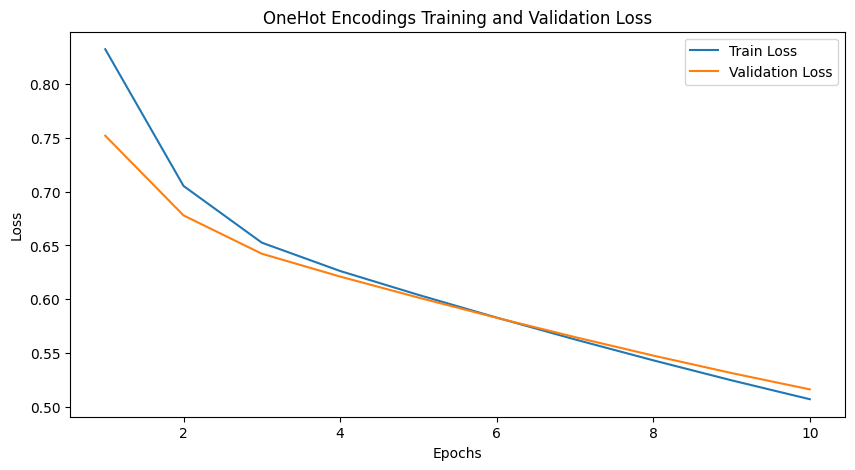

Model Training Time: 5.330231189727783 seconds


In [25]:
# TRAIN 
start_time = time.time()

onehotpredictor = train_validation_loop("OneHot Encodings",300, train_encodings, train_labels, val_encodings, val_labels)

end_time = time.time()
full_model_training_time = end_time - start_time
print(f"Model Training Time: {full_model_training_time} seconds")

### ProtVec

In [26]:
# Prepare train and validation protvec representations
train_encodings = [prepare_ProtVec(seq.upper(),TrigramToVec) for seq in X_train ]
val_encodings = [prepare_ProtVec(seq.upper(),TrigramToVec) for seq in X_val ]

/tmp/ipykernel_219219/745720336.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  tr_encodings = torch.tensor(train_encodings[start_idx:end_idx])
/tmp/ipykernel_219219/745720336.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tr_encodings = torch.tensor(tr_encodings, dtype=torch.float32)


Epoch [1/10], Train Loss: 0.8137, Validation Loss: 0.8038
Epoch [2/10], Train Loss: 0.7829, Validation Loss: 0.7155
Epoch [3/10], Train Loss: 0.6975, Validation Loss: 0.6765
Epoch [4/10], Train Loss: 0.6777, Validation Loss: 0.6756
Epoch [5/10], Train Loss: 0.6751, Validation Loss: 0.6715
Epoch [6/10], Train Loss: 0.6718, Validation Loss: 0.6683
Epoch [7/10], Train Loss: 0.6686, Validation Loss: 0.6651
Epoch [8/10], Train Loss: 0.6653, Validation Loss: 0.6618
Epoch [9/10], Train Loss: 0.6621, Validation Loss: 0.6587
Epoch [10/10], Train Loss: 0.6589, Validation Loss: 0.6555


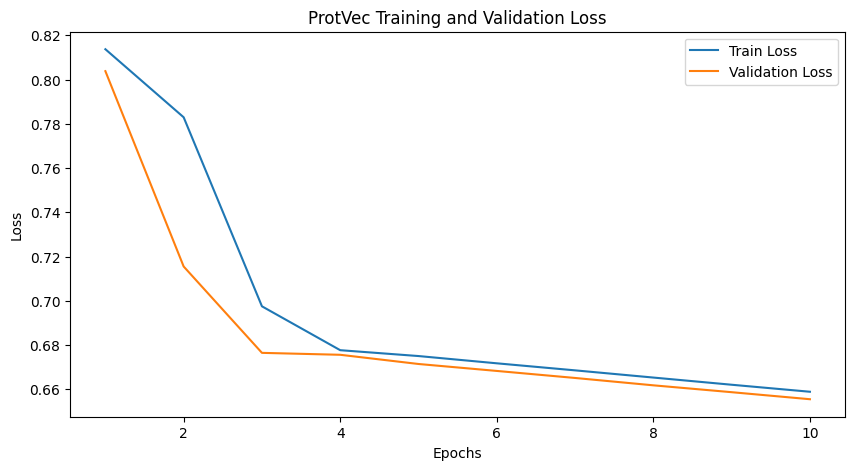

Model Training Time: 1.3548367023468018 seconds


In [27]:
# TRAIN
start_time = time.time()

protvecpredictor = train_validation_loop("ProtVec", 100, train_encodings, train_labels, val_encodings, val_labels)

end_time = time.time()
full_model_training_time = end_time - start_time
print(f"Model Training Time: {full_model_training_time} seconds")

### ProtBERT

In [37]:
# Prepare validation and train sequences by obeying the input processing rule of ProtBERT
protbert_X_train = list(map(lambda x: re.sub(r"[UZOB]", "X", " ".join(list(x.upper()))).replace("_","-"), X_train))
protbert_X_val = list(map(lambda x: re.sub(r"[UZOB]", "X", " ".join(list(x.upper()))).replace("_","-"), X_val))

Epoch [1/10], Train Loss: 0.6407, Validation Loss: 0.6990
Epoch [2/10], Train Loss: 0.6642, Validation Loss: 0.6451
Epoch [3/10], Train Loss: 0.6380, Validation Loss: 0.6270
Epoch [4/10], Train Loss: 0.6220, Validation Loss: 0.6127
Epoch [5/10], Train Loss: 0.6091, Validation Loss: 0.6012
Epoch [6/10], Train Loss: 0.5982, Validation Loss: 0.5917
Epoch [7/10], Train Loss: 0.5886, Validation Loss: 0.5834
Epoch [8/10], Train Loss: 0.5799, Validation Loss: 0.5759
Epoch [9/10], Train Loss: 0.5717, Validation Loss: 0.5690
Epoch [10/10], Train Loss: 0.5640, Validation Loss: 0.5626


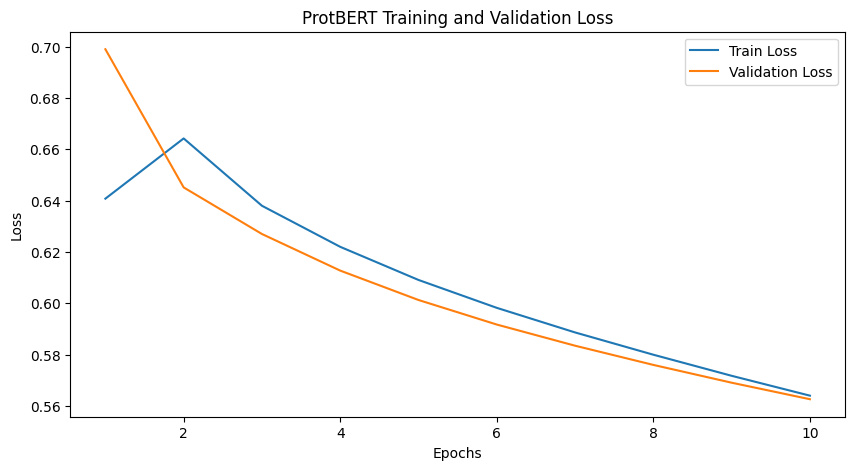

Model Training Time: 92.16055941581726 seconds


In [38]:
# TRAIN
start_time = time.time()

protbertpredictor = train_validation_loop_plm("ProtBERT", protbertmodel, protberttokenizer,1024, protbert_X_train, train_labels, protbert_X_val, val_labels)

end_time = time.time()
full_model_training_time = end_time - start_time
print(f"Model Training Time: {full_model_training_time} seconds")

### ESM2

In [39]:
# Prepare validation and train sequences by obeying the input processing rule of ESM2
esm_X_train = list(map(lambda x: x.replace("_","-").upper(), X_train))
esm_X_val = list(map(lambda x: x.replace("_","-").upper(), X_val))

Epoch [1/10], Train Loss: 0.6698, Validation Loss: 0.6990
Epoch [2/10], Train Loss: 0.6550, Validation Loss: 0.6282
Epoch [3/10], Train Loss: 0.6246, Validation Loss: 0.6105
Epoch [4/10], Train Loss: 0.6113, Validation Loss: 0.6004
Epoch [5/10], Train Loss: 0.6017, Validation Loss: 0.5929
Epoch [6/10], Train Loss: 0.5935, Validation Loss: 0.5861
Epoch [7/10], Train Loss: 0.5862, Validation Loss: 0.5797
Epoch [8/10], Train Loss: 0.5796, Validation Loss: 0.5741
Epoch [9/10], Train Loss: 0.5735, Validation Loss: 0.5685
Epoch [10/10], Train Loss: 0.5678, Validation Loss: 0.5633


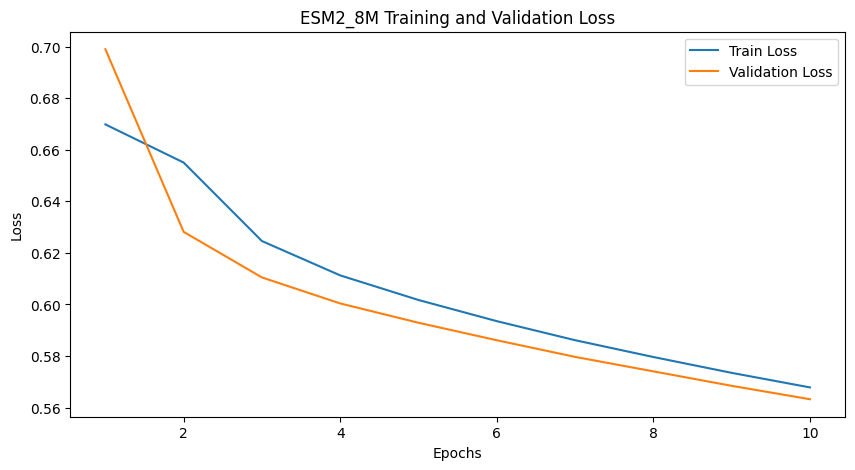

Model Training Time: 7.758981704711914 seconds


In [40]:
start_time = time.time()

esmpredictor = train_validation_loop_plm("ESM2_8M",esmmodel, esmtokenizer,320, esm_X_train, train_labels, esm_X_val, val_labels)

end_time = time.time()
full_model_training_time = end_time - start_time
print(f"Model Training Time: {full_model_training_time} seconds")

## Evaluation

In this section, you can evaluate each trained predictor on the test split. Before evaluation, you should first prepare test input sequences according to correct format, that is, in which format predictor accepts the input. Since there are 2 distinct predictor classes (processing the data and feeding to the model steps are different in baseline approaches(OneHot Encoding) and transformer based approaches(ProtBERT, ESM2)), there are small differences in evaluating test sequences as well.

In [41]:
# onehot representation
onehot_test_encodings = [one_hot_encode(seq) for seq in X_test]
# protvec representation
protvec_test_encodings = [prepare_ProtVec(seq.upper(),TrigramToVec) for seq in X_test]
# protbert compatible preprocessing of sequences
protbert_X_test = list(map(lambda x: re.sub(r"[UZOB]", "X", " ".join(list(x.upper()))).replace("_","-"), X_test))
# esm2 compatible preprocessing of sequences
esm_X_test = list(map(lambda x: x.replace("_","-").upper(), X_test))

In [42]:
"""
modelname: model name
predictor: trained predictor
test_encodings: pre-calculated encodings 
test_labels: labels of test samples
batch_size: 256
"""

def evaluate(modelname, predictor, test_encodings, test_labels, batch_size=256):
    predictor.eval()  # evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []

    print(modelname, "evaluation results on test set:")
    
    with torch.no_grad(): 
        # number of batches
        num_batches = len(X_test) // batch_size
        
        for i in range(num_batches):
            
            # batch indices
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            # vector representations of  batch
            test_representations = test_encodings[start_idx:end_idx]

            test_representations = torch.tensor(test_representations, dtype=torch.float32)  
            labels = torch.tensor(test_labels[start_idx:end_idx], dtype=torch.long)
            
            # provide representation vectors to predictor
            outputs = predictor(test_representations) 
            
            # Apply softmax to convert model output to probability
            probabilities = torch.softmax(outputs, dim=1)
            
            # find predicted class 
            _, predicted = torch.max(outputs, 1)
            
            # compare predictions with true labels
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # save labels, predictions and prediction probabilities 
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())  

    # Accuracy
    accuracy = 100 * correct / total

    # F1 score and AUC
    f1 = f1_score(all_labels, all_predictions)  
    auc = roc_auc_score(all_labels, all_probabilities) 

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'F1 Score: {f1:.2f}')
    print(f'AUC: {auc:.2f}')
    



In [43]:
"""
modelname: model name
predictor: trained predictor
tokenizer: tokenizer for corresponding predictor model 
X_test: test sequences
test_labels: labels of test samples
batch_size: 256
"""
def evaluate_plm(modelname, predictor, tokenizer, X_test, test_labels, batch_size=256):
    predictor.eval() # evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []

    print(modelname, "evaluation results on test set:")
    with torch.no_grad():
        
        # number of batches
        num_batches = len(X_test) // batch_size
        
        for i in range(num_batches):
            
            # batch indices
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            # batch sequences
            test_sequences = X_test[start_idx:end_idx]
            
            # tokenize batch sequences 
            test_tokens = tokenizer(test_sequences, return_tensors="pt", padding="max_length", max_length=17)
            
            # provide token ids to predictor
            outputs = predictor(test_tokens.to("cuda"))
            
            # Apply softmax to convert model output to probability
            probabilities = torch.softmax(outputs, dim=1)
            
            # find predicted class 
            _, predicted = torch.max(outputs, 1)
            labels = test_labels[start_idx:end_idx].to("cuda")
            
            # compare predictions with true labels
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # save labels, predictions and prediction probabilities 
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())  

    # Accuracy
    accuracy = 100 * correct / total

    # F1-Score and AUC 
    f1 = f1_score(all_labels, all_predictions) 
    auc = roc_auc_score(all_labels, all_probabilities)  

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'F1 Score: {f1:.2f}')
    print(f'AUC: {auc:.2f}')
    


In [44]:
evaluate("OneHotEncoding",onehotpredictor, onehot_test_encodings, test_labels)

OneHotEncoding evaluation results on test set:
Test Accuracy: 75.47%
F1 Score: 0.76
AUC: 0.83


/tmp/ipykernel_219219/1907537377.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(test_labels[start_idx:end_idx], dtype=torch.long)


In [45]:
evaluate("ProtVec",protvecpredictor, protvec_test_encodings, test_labels)

ProtVec evaluation results on test set:
Test Accuracy: 64.06%
F1 Score: 0.63
AUC: 0.69


/tmp/ipykernel_219219/1907537377.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(test_labels[start_idx:end_idx], dtype=torch.long)


In [46]:
evaluate_plm("ProtBERT",protbertpredictor,protberttokenizer, protbert_X_test, test_labels)

ProtBERT evaluation results on test set:
Test Accuracy: 69.30%
F1 Score: 0.72
AUC: 0.77


In [47]:
evaluate_plm("ESM2_8M",esmpredictor,esmtokenizer, esm_X_test, test_labels)

ESM2_8M evaluation results on test set:
Test Accuracy: 70.08%
F1 Score: 0.75
AUC: 0.80


### What if we use ESM2 with 650M parameters?

In [48]:
#  Load model
modelname = "facebook/esm2_t33_650M_UR50D"
esmbigmodel = AutoModel.from_pretrained(modelname).to("cuda")
esmbigtokenizer = AutoTokenizer.from_pretrained(modelname)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
# Prepare validation and train sequences by obeying the input processing rule of ESM2
esm_X_train = list(map(lambda x: x.replace("_","-").upper(), X_train))
esm_X_val = list(map(lambda x: x.replace("_","-").upper(), X_val))

Epoch [1/50], Train Loss: 0.6142, Validation Loss: 0.6784
Epoch [2/50], Train Loss: 0.6693, Validation Loss: 0.6608
Epoch [3/50], Train Loss: 0.6548, Validation Loss: 0.6478
Epoch [4/50], Train Loss: 0.6448, Validation Loss: 0.6390
Epoch [5/50], Train Loss: 0.6369, Validation Loss: 0.6308
Epoch [6/50], Train Loss: 0.6303, Validation Loss: 0.6237
Epoch [7/50], Train Loss: 0.6251, Validation Loss: 0.6185
Epoch [8/50], Train Loss: 0.6198, Validation Loss: 0.6131
Epoch [9/50], Train Loss: 0.6149, Validation Loss: 0.6084
Epoch [10/50], Train Loss: 0.6105, Validation Loss: 0.6031
Epoch [11/50], Train Loss: 0.6062, Validation Loss: 0.5988
Epoch [12/50], Train Loss: 0.6021, Validation Loss: 0.5942
Epoch [13/50], Train Loss: 0.5980, Validation Loss: 0.5897
Epoch [14/50], Train Loss: 0.5943, Validation Loss: 0.5859
Epoch [15/50], Train Loss: 0.5904, Validation Loss: 0.5815
Epoch [16/50], Train Loss: 0.5871, Validation Loss: 0.5777
Epoch [17/50], Train Loss: 0.5831, Validation Loss: 0.5743
Epoch 

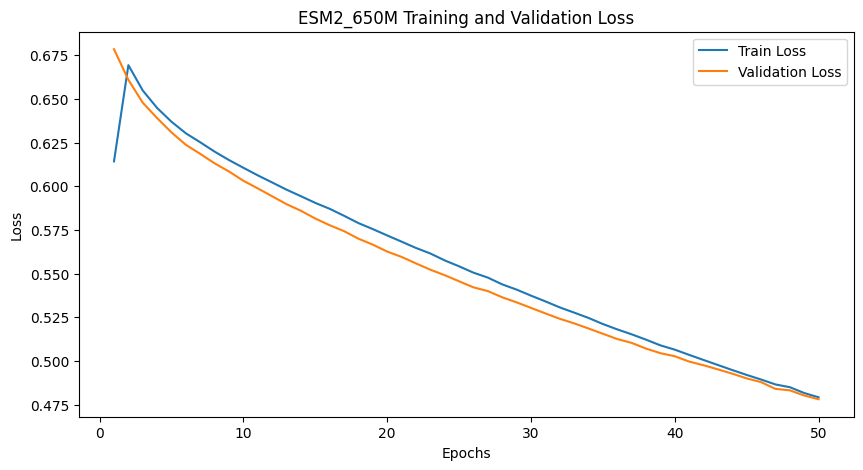

Model Training Time: 874.8688189983368 seconds


In [52]:
start_time = time.time()

esmbigpredictor = train_validation_loop_plm("ESM2_650M",esmbigmodel, esmbigtokenizer,1280, esm_X_train, train_labels, esm_X_val, val_labels, num_epochs=50)

end_time = time.time()
full_model_training_time = end_time - start_time
print(f"Model Training Time: {full_model_training_time} seconds")

In [53]:
evaluate_plm("ESM2_650M",esmbigpredictor,esmbigtokenizer, esm_X_test, test_labels)

ESM2_650M evaluation results on test set:
Test Accuracy: 77.27%
F1 Score: 0.80
AUC: 0.87
